# EE 617 Sensors in Instrumentation
## Assignment 02

### Part A - Obtaining the Periodogram and Allan Deviation of a provided dataset

In [1]:
import math
import numpy as np
import unicodedata
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
%matplotlib inline
realG = 9.78068
directory = '.\Part_1\\'

`fileListGen` makes a list of files to take input values from, and `fileRead` outputs a tuple conglomerated from the data points.

In [2]:
def fileListGen(dir, ext):
    fileList = []
    for file in listdir(dir):
        if isfile(join(dir, file)) and file.endswith(ext):
            fileList.append(file)
    return fileList

In [3]:
def fileRead(v, dir, file, ignore, sampleRate = 1):
    with open(dir + file) as f:
        content = f.readlines()
    content = content[ignore:]        # Remove description
    length = len(content)
    
    for i in range(length):
        iter = 0
        data = []
        temp = ''
        for iter in content[i]:
            if iter == ',':
                data.append(temp)
                temp = ''
            else:
                temp += iter
        data.append(temp)
        if len(data) == 1:
            v[0].append(i/sampleRate)
            v[1].append(float(data[0]))
        else:
            index = float(data[0])/sampleRate
            if index not in v[0]:
                v[0].append(index)
                for j in range(1, len(v)):
                    v[j].append(float(data[j]))
    return v

v = ([], [])
v = fileRead(v, directory, 'Dataset_01.csv', 1)

We can use `allanDev` to compute the Allan Deviation for a single bin size `width` given the time series `t` and the data points `arr`

In [4]:
def allanDev(t, arr, width):
    avar = 0
    diff = []
    for i in range(1, int(len(arr)/width)):
        avar += (np.mean(arr[i*width:(i+1)*width]) - np.mean(arr[(i-1)*width:i*width]) ) ** 2 
    avar = avar / (2 * int(len(arr)/width))
    adev = math.sqrt(avar)
    return adev

Now we compute the entire Allan Deviation curve for all bin widths from $1$ to $\frac{N}{9}$ where $N$ is the total number of data points

In [5]:
adevs = []
dispLength = int(len(v[0])/9)
for width in range(1, dispLength):
    adevs.append(allanDev(v[0], v[1], width))
xvals = [(i+1)*0.05 for i in range(len(adevs))]

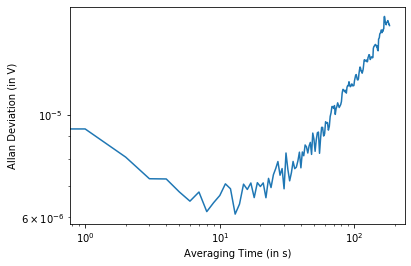

In [6]:
plt.xlabel("Averaging Time (in s)")
plt.ylabel("Allan Deviation (in V)")
plt.loglog(adevs)
plt.show()

The bias stability is obtained as the minimum value of Allan deviation and the noise density as the value of Allan deviation at an averaging time of one second.

In [7]:
print("Bias stability = ", str(round(10**6 * min(adevs), 5)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "V")
print("Noise density  = ", str(round(10**6 * allanDev(v[0], v[1], 1), 4)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "V/" + unicodedata.lookup("SQUARE ROOT") + "Hz")

Bias stability =  6.09028 μV
Noise density  =  12.7344 μV/√Hz


### Part B - Measuring accelerometer readings and analyzing the corresponding information

In [8]:
directory = '.\Part_2\\'
files = fileListGen(directory, '.txt')
print(files)

['Accelerometer Data 2020-08-31 13-21-28.txt', 'Accelerometer Data 2020-08-31 13-24-28.txt', 'Accelerometer Data 2020-08-31 13-27-25.txt', 'Accelerometer Data 2020-08-31 13-29-24.txt', 'Accelerometer Data 2020-08-31 13-31-25.txt', 'Accelerometer Data 2020-08-31 13-18-43.txt']


In [9]:
v = tuple([] for i in range(7))
for file in files:
    v = fileRead(v, directory, file, 4, 1)

for i in range(1, len(v[0])):
    v[1][i] /= realG
    v[1][i] /= realG
    v[1][i] /= realG

#### Sub-Part A
We can plot the periodogram and Allan deviation plots for the readings on each axis considering the power spectral density of the voltage with respect to frequency:

In [10]:
adevs = ([], [], [])
dispLength = int(len(v[0])/9)
for width in range(1, dispLength):
    adevs[0].append(allanDev(v[0], v[1], width))
    adevs[1].append(allanDev(v[0], v[2], width))
    adevs[2].append(allanDev(v[0], v[3], width))
xvals = [(i+1)*0.05 for i in range(len(adevs))]

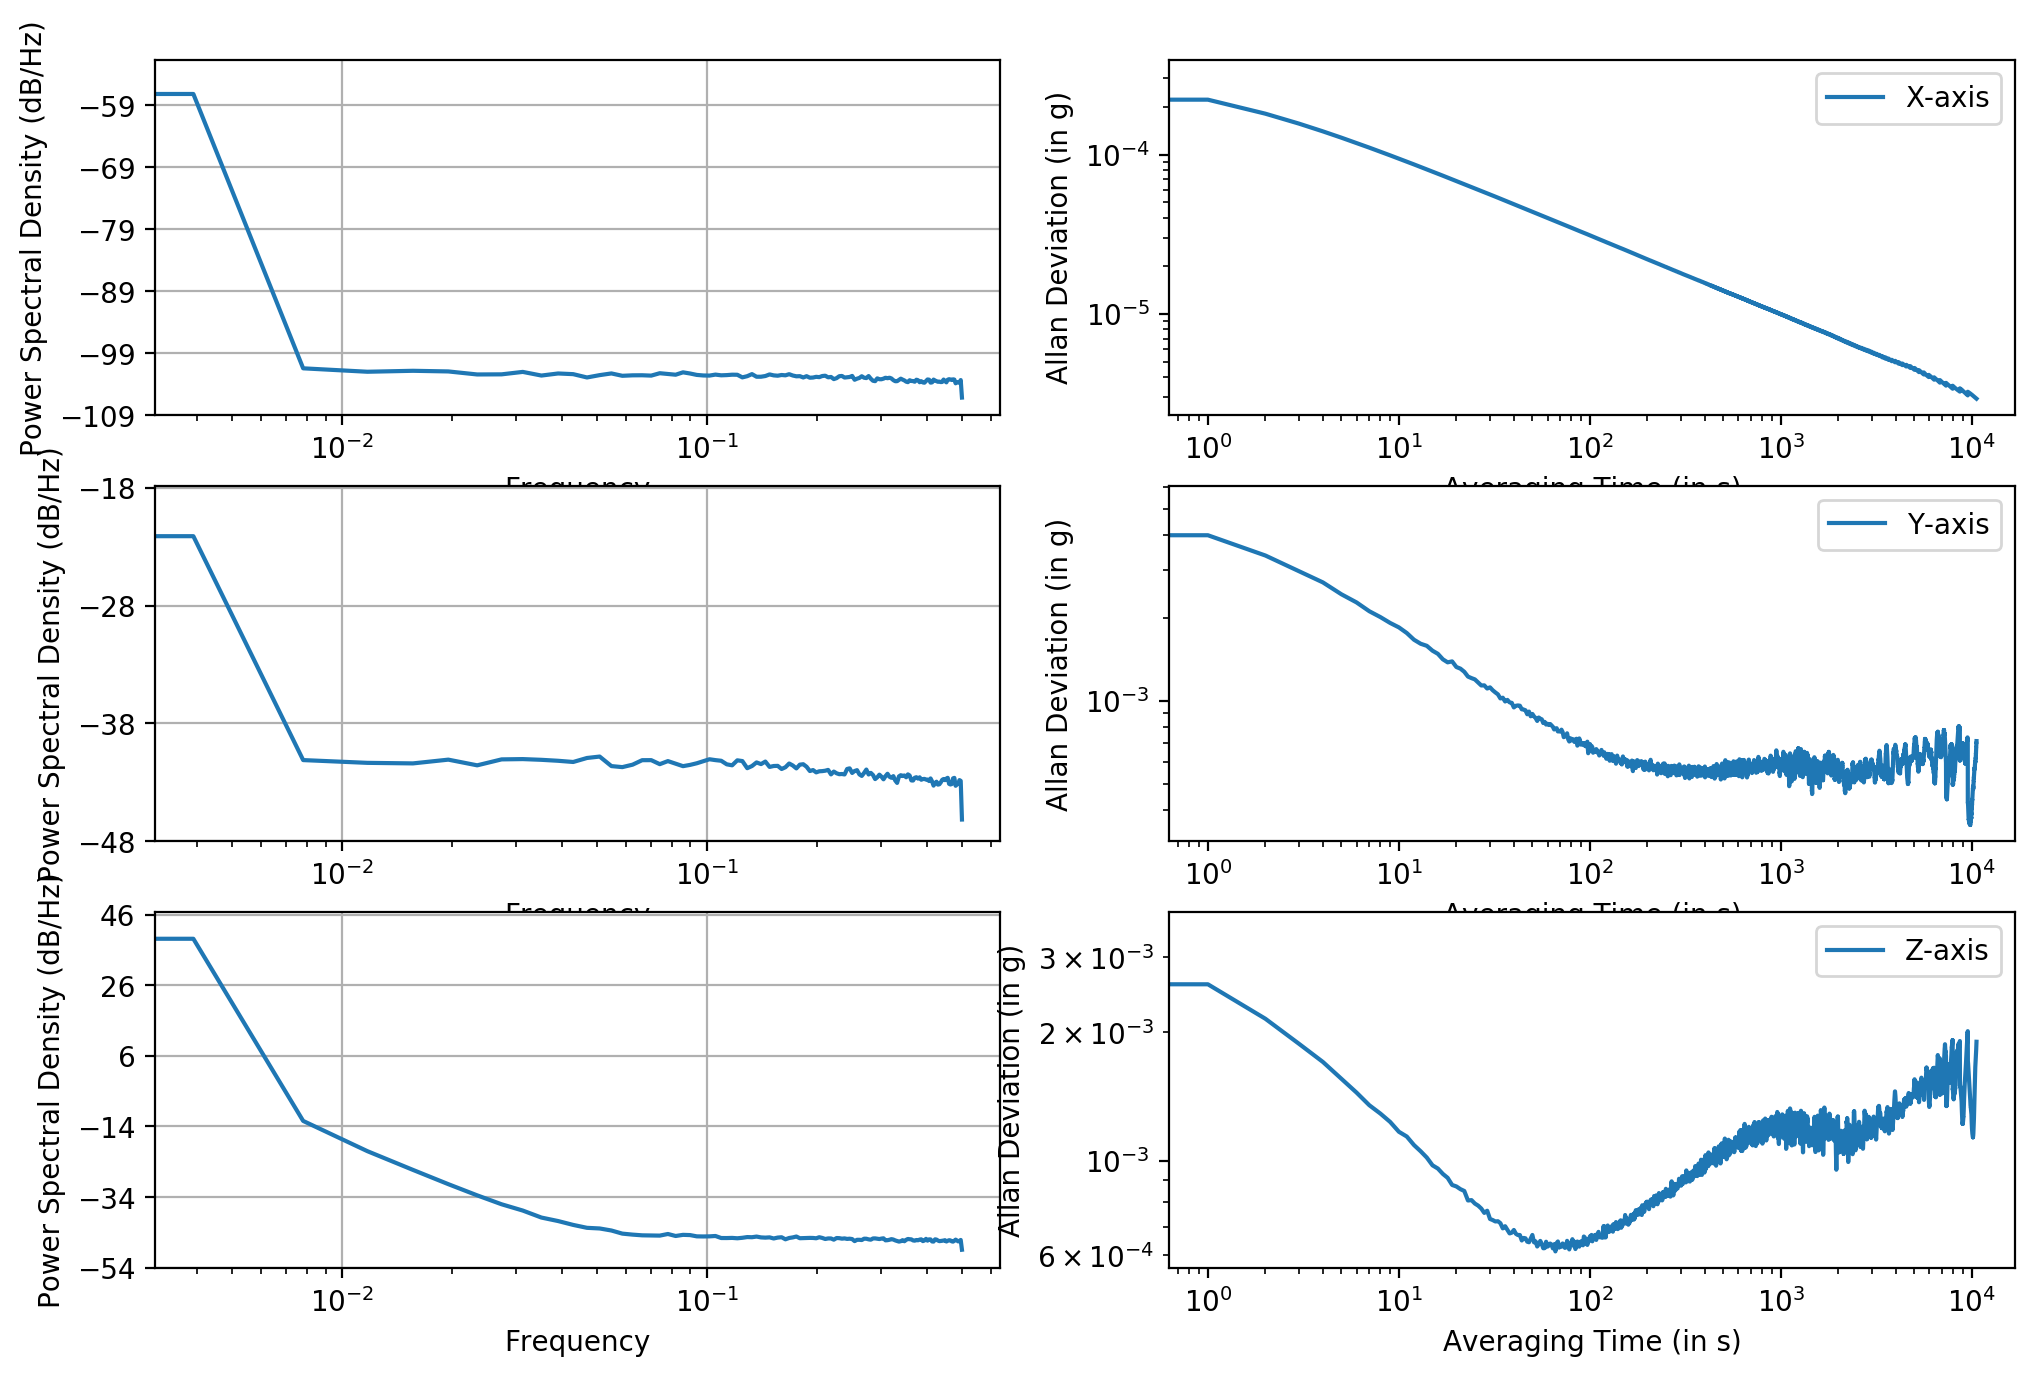

In [11]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

xPer = plt.subplot(3,2,1)
xPer.set_xscale('log')
xPer.set_ylabel("X-axis PSD (in dB/Hz)")
xPer.psd(v[1], Fs = 1)
xAll = plt.subplot(3,2,2)
xAll.set_xlabel("Averaging Time (in s)")
xAll.set_ylabel("Allan Deviation (in g)")
xAll.loglog(adevs[0], label='X-axis')
xAll.legend(loc='best')

yPer = plt.subplot(3,2,3)
yPer.set_xscale('log')
yPer.set_ylabel("Y-axis PSD (in dB/Hz)")
yPer.psd(v[2], Fs = 1)
yAll = plt.subplot(3,2,4)
yAll.set_xlabel("Averaging Time (in s)")
yAll.set_ylabel("Allan Deviation (in g)")
yAll.loglog(adevs[1], label='Y-axis')
yAll.legend(loc='best')

zPer = plt.subplot(3,2,5)
zPer.set_xscale('log')
zPer.set_ylabel("Z-axis PSD (in dB/Hz)")
zPer.psd(v[3], Fs = 1)
zAll = plt.subplot(3,2,6)
zAll.set_xlabel("Averaging Time (in s)")
zAll.set_ylabel("Allan Deviation (in g)")
zAll.loglog(adevs[2], label='Z-axis')
zAll.legend(loc='best')

plt.show()

There _seems_ to be an inconsistency in the **X-axis** readings. However, it is clear from the periodogram that the readings obtained for the X-axis are much smaller (about 40 dB) that the other readings. Moreover, the _only non-white component of noise is Brown noise_ that is not significantly visible in the Allan deviation plot possibly due to its negligiblly small values and very short range of frequency.  
The **Y-axis** readings are also consistent with the periodogram since _Brown noise is absent_ and the graph remains flat after the dip because of the pink noise component. _All three forms of noise_ is visible in the **Z-axis** readings which is clearly visible in both the periodogram and the Allan deviation plot, since the former has two downward slopes before it flattens and the latter rises unlike the Y-axis plot.

#### Sub-Part B
From the Allan deviation, we obtain the noise densities of each axis as the value at an averaging time of 1 second:

In [12]:
print("X-axis noise density  = ", str(round(10**6 * allanDev(v[0], v[1], 1), 4)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "g/" + unicodedata.lookup("SQUARE ROOT") + "Hz")
print("Y-axis noise density  = ", str(round(10**6 * allanDev(v[0], v[2], 1), 4)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "g/" + unicodedata.lookup("SQUARE ROOT") + "Hz")
print("Z-axis noise density  = ", str(round(10**6 * allanDev(v[0], v[3], 1), 4)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "g/" + unicodedata.lookup("SQUARE ROOT") + "Hz")

X-axis noise density  =  312.3922 μg/√Hz
Y-axis noise density  =  5278.6821 μg/√Hz
Z-axis noise density  =  3504.7911 μg/√Hz


Since a proper datasheet was not available for the IMU sensor, parameters of the sensor were taken from other sources and noise density was not provided as part of these parameters.

#### Sub-Part C
From assignment 1, based on the information given by [phyphox.org](https://phyphox.org), the resolution of the K6DS3TR IMU accelerometer is $0.0012\ ms^{-2}$ which corresponds to about $122.6909\ \mu g$. According to the readings obtained from the _Accelerometer Meter_ application, this resolution, which is the smallest change in acceleration that can be measured with each axis of the accelerometer with averaging, should be equivalent to the bias stability of the sensor. This is given as the minimum value of the Allan deviation of the sensor readings:

In [13]:
print("X-axis bias stability = ", str(round(10**6 * min(adevs[0]), 5)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "g")
print("Y-axis bias stability = ", str(round(10**6 * min(adevs[1]), 5)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "g")
print("Z-axis bias stability = ", str(round(10**6 * min(adevs[2]), 5)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "g")

X-axis bias stability =  2.93391 μg
Y-axis bias stability =  353.1349 μg
Z-axis bias stability =  612.13766 μg


The X-axis values are very small as noticed earlier in the periodogram and the Allan deviation plot. The Y-axis and Z-axis bias stabilities show that the accelerometer has a resolution in the same range but many times larger than that mentioned by the manufacturer.

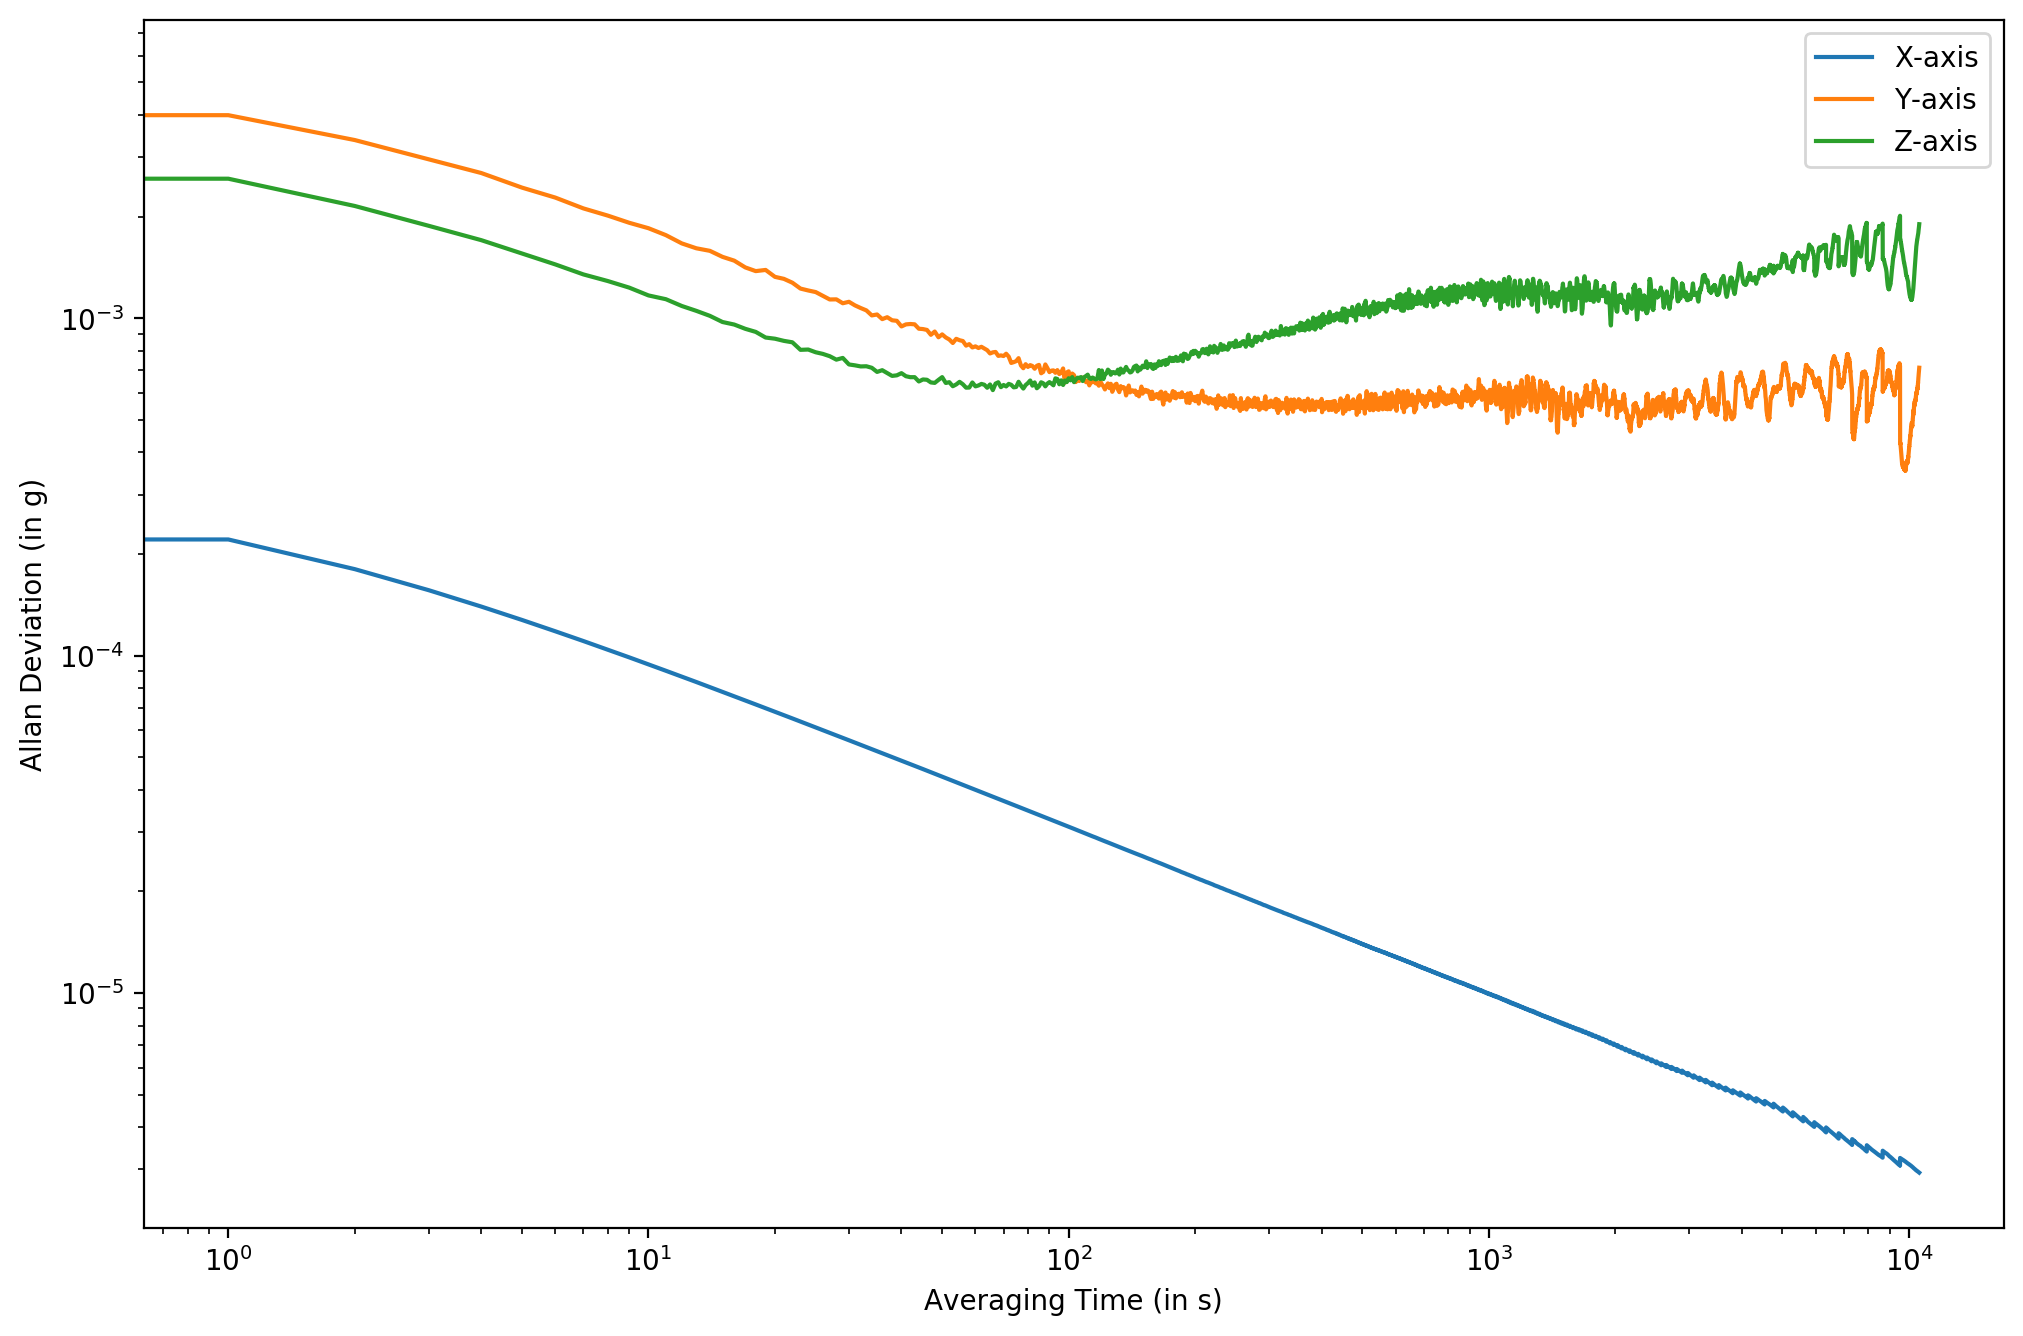

In [14]:
plt.xlabel("Averaging Time (in s)")
plt.ylabel("Allan Deviation (in g)")
plt.loglog(adevs[0], label='X-axis')
plt.loglog(adevs[1], label='Y-axis')
plt.loglog(adevs[2], label='Z-axis')
plt.legend(loc='best')
plt.show()

#### Sub-Part D
On plotting all three Allan deviation diagrams on the same plot as given above, we notice that the offset drift of the Z-axis is highest of all three axes owing to the positive slope after a point. The Y-axis readings display the presence of more white and pink noise, and it is expected to have negligible offset drift. As mentioned earlier, the X-axis readings show very little sign of Brown noise and no sign at all of pink noise, as a result of which the Allan deviation plot has a negative slope throughout. Offset drift is not expected for this axis, and on averaging with larger bin sizes, it is always expected to smaller deviation.

In [15]:
noise = 0
for i in range(len(v[3])):
    noise += (v[3][i]/realG - 1.0)**2
noise = np.sqrt(noise/len(v[3]))
print("RMS Noise of Z-axis accelerometer = " + str(round(10**6 * noise, 6)) + " " + unicodedata.lookup("GREEK SMALL LETTER MU") + "g")

RMS Noise of Z-axis accelerometer = 498.207502 μg


#### Sub-Part E
The value of RMS noise as measured in the previous assignment was $0.00655\ ms^{−2}$, i.e. $669.6876\ \mu g$, hence showing that the actual accelerometer readings contain noise within the limits mentioned by the manufacturer.

### Acknowledgments

As mentioned earlier, information about the IMU sensor on the mobile phone was taken from [phyphox.org](https://phyphox.org) which is managed by RWTH Aachen University. StackOverflow links and other webpages used for help in coding the the assignment include but are not limited to:
 - [A Cheatsheet for Markdown in Jupyter](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)
 
 - [matplotlib and subplots properties](https://stackoverflow.com/questions/38662667/matplotlib-and-subplots-properties)
 
 - [Matplotlib.axes.Axes.psd](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.psd.html)
 
 - [multiple plot in one figure in Python](https://stackoverflow.com/questions/21254472/multiple-plot-in-one-figure-in-python)
 
 - [Install python packages on Jupyter Notebook](https://stackoverflow.com/questions/54801963/install-python-packages-on-jupyter-notebook)
 
 - [Creating a log-frequency axis spectrogram using specgram in matplotlib](https://stackoverflow.com/questions/10812189/creating-a-log-frequency-axis-spectrogram-using-specgram-in-matplotlib)
 
 - [How to make inline plots in Jupyter Notebook larger?](https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger)
 
 - [matplotlib power spectral density (PSD) value discrepancy](https://stackoverflow.com/questions/27519737/matplotlib-power-spectral-density-psd-value-discrepancy)
 
 - [Encoding multiple columns](https://stackoverflow.com/questions/63779875/encoding-multiple-columns)
 
 - [plt.subplot in jupyter notebook](https://stackoverflow.com/questions/49568625/plt-subplot-in-jupyter-notebook)
 
 - [Superscript in markdown (Github flavored)?](https://stackoverflow.com/questions/15155778/superscript-in-markdown-github-flavored)
 
 - [Printing greek letters using sympy in text](https://stackoverflow.com/questions/26483891/printing-greek-letters-using-sympy-in-text)